### Add scripts path to the notebook

In [107]:
import sys
import os

current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

scripts_path = os.path.join(parent_dir, 'scripts')

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
sys.path.insert(0, scripts_path)

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

d:\KifiyaAIM-Course\Week - 2\TellCo-Profitability-Opportunity-Analysis\notebooks


### Import Statements

In [108]:
import math
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

from scripts.database_client import DB_Client
from scripts.data_cleaner import DataCleaner
from scripts.user_satisfaction import UserStatisfactionCalculator

In [141]:
sns.set_theme()

### Initialize DB_Client

In [109]:
# obtain values form environment variables
host = os.getenv("DB_HOST")
user_name = os.getenv("DB_USER")
passowrd = os.getenv("DB_PASSWORD")
port = os.getenv("DB_PORT")
database = os.getenv("DB_NAME")

In [110]:
db_client = DB_Client(
    host=host,
    user_name=user_name,
    password=passowrd,
    port=port,
    database_name=database
)

### Load the data from the database

In [111]:
data = db_client.dump_data()

d:\KifiyaAIM-Course\Week - 2\TellCo-Profitability-Opportunity-Analysis\scripts\database_client.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  response = pd.read_sql_query(sql=query, con=self.connection)


### Clean the data

1) Initialize the data cleaner

In [112]:
cleaner = DataCleaner(data=data)

2) Clean the experience data

In [113]:
# define the columns of interest
columns_of_interest = ["MSISDN/Number", "Avg RTT DL (ms)", "Avg RTT UL (ms)", "TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)", "Handset Type", "Avg Bearer TP DL (kbps)", "Avg Bearer TP UL (kbps)"]

# define columns where we will use mode to replace the NA values
mode_columns = ["MSISDN/Number", "Handset Type"]

# define columns where we will use mean to replace the NA values
mean_columns = [col for col in columns_of_interest if col not in mode_columns]

In [114]:
# clean the categorical data(ones who use mode for their NA)
data[mode_columns] = cleaner.fill_na(columns=mode_columns, method='mode')

# clean the numeric data(ones who use mean for their NA)
data[mean_columns] = cleaner.fill_na(columns=mean_columns, method='mean')

# print out the final result
data[[*mean_columns, *mode_columns]].isna().mean()

Avg RTT DL (ms)                0.0
Avg RTT UL (ms)                0.0
TCP DL Retrans. Vol (Bytes)    0.0
TCP UL Retrans. Vol (Bytes)    0.0
Avg Bearer TP DL (kbps)        0.0
Avg Bearer TP UL (kbps)        0.0
MSISDN/Number                  0.0
Handset Type                   0.0
dtype: float64

3) Clean the engagement data

In [115]:
columns_of_interest = ["Start", "Start ms", "End", "End ms", "Dur. (ms)", "Dur. (ms).1"]

In [116]:
cleaner.find_na()

Bearer Id                                   0.006607
Start                                       0.000007
Start ms                                    0.000007
End                                         0.000007
End ms                                      0.000007
Dur. (ms)                                   0.000007
IMSI                                        0.003800
MSISDN/Number                               0.000000
IMEI                                        0.003813
Last Location Name                          0.007687
Avg RTT DL (ms)                             0.000000
Avg RTT UL (ms)                             0.000000
Avg Bearer TP DL (kbps)                     0.000000
Avg Bearer TP UL (kbps)                     0.000000
TCP DL Retrans. Vol (Bytes)                 0.000000
TCP UL Retrans. Vol (Bytes)                 0.000000
DL TP < 50 Kbps (%)                         0.005027
50 Kbps < DL TP < 250 Kbps (%)              0.005027
250 Kbps < DL TP < 1 Mbps (%)               0.

In [117]:
data = cleaner.drop_na()
data.isna().mean()

Bearer Id                                   0.0
Start                                       0.0
Start ms                                    0.0
End                                         0.0
End ms                                      0.0
Dur. (ms)                                   0.0
IMSI                                        0.0
MSISDN/Number                               0.0
IMEI                                        0.0
Last Location Name                          0.0
Avg RTT DL (ms)                             0.0
Avg RTT UL (ms)                             0.0
Avg Bearer TP DL (kbps)                     0.0
Avg Bearer TP UL (kbps)                     0.0
TCP DL Retrans. Vol (Bytes)                 0.0
TCP UL Retrans. Vol (Bytes)                 0.0
DL TP < 50 Kbps (%)                         0.0
50 Kbps < DL TP < 250 Kbps (%)              0.0
250 Kbps < DL TP < 1 Mbps (%)               0.0
DL TP > 1 Mbps (%)                          0.0
UL TP < 10 Kbps (%)                     

### Assign Satisfaction score to users

In [118]:
satisfaction_calc = UserStatisfactionCalculator(data=data)

1) Assign experience score for users

In [119]:
# obtain the experience clusters
experience_clusters = satisfaction_calc.get_experience_cluster()

Created a normalizer


In [120]:
experience_score = satisfaction_calc.claculate_experience_score()

2) Assign engagement score for users

In [121]:
# obtain the experience clusters
engagement_clusters = satisfaction_calc.get_engagement_cluster()

Created a normalizer


In [122]:
engagement_score = satisfaction_calc.calculate_engagement_score()

3) Calculate the satisfaction score of users using engagement score and experience score and print top 10 customers

In [123]:
# calculate the satisfaction scores of the users
satisfaction_scores = satisfaction_calc.get_satifisfaction_score(engagemet_score=engagement_score['engagement_score'], experience_score=experience_score['experience_score'])

- Add the metrics to a new dataframe

In [124]:
engagement_score['experience_score'] = experience_score['experience_score']
engagement_score['satisfaction_score'] = satisfaction_scores

unwanted_cols = [col for col in engagement_score.columns if col not in ['experience_score', 'satisfaction_score', 'engagement_score']]
user_data = engagement_score.drop(columns=unwanted_cols)

Print the top 10 users with regards to satisfaction score

In [125]:
user_data.sort_values(by='satisfaction_score', ascending=False).head(10)

,engagement_score,experience_score,satisfaction_score
MSISDN/Number,,,
3.362632e+10,4.433729e+10,3.938102e+06,2.217062e+10
3.365955e+10,6.712507e+09,2.171065e+06,3.357339e+09
3.369925e+10,5.151779e+09,1.732802e+07,2.584554e+09
3.365073e+10,5.155759e+09,7.295040e+06,2.581527e+09
3.366180e+10,5.111951e+09,5.005221e+06,2.558478e+09
3.366258e+10,5.107097e+09,3.966170e+06,2.555531e+09
3.376264e+10,4.491789e+09,5.879989e+08,2.539894e+09
3.366969e+10,4.948515e+09,3.338826e+06,2.475927e+09
3.365813e+10,4.895647e+09,1.900829e+06,2.448774e+09


4) Apply k means of k=2 for both experinece score and satisfaction score

- Initialize clusterer

In [126]:
clusterer = KMeans(n_clusters=2, random_state=7, init='k-means++', n_init=50)

- Classify based on experience score

In [127]:
experience_clusters = clusterer.fit(user_data.drop(columns=['engagement_score', 'satisfaction_score']))

- Classify based on engagement score

In [128]:
engagement_clusters = clusterer.fit(user_data.drop(columns=['satisfaction_score', 'experience_score']))

5) Aggregate the average satisfaction & experience score

In [129]:
# first add the labels for the cluster each user belongs to
user_data['engagement_cluster'] = engagement_clusters.labels_
user_data['experience_cluster'] = experience_clusters.labels_

In [132]:
# aggregate the user data based on engagement cluster
engagement_avg_aggregate = user_data.groupby(by='engagement_cluster').agg({
    "satisfaction_score": "mean",
    "experience_score": "mean"
})

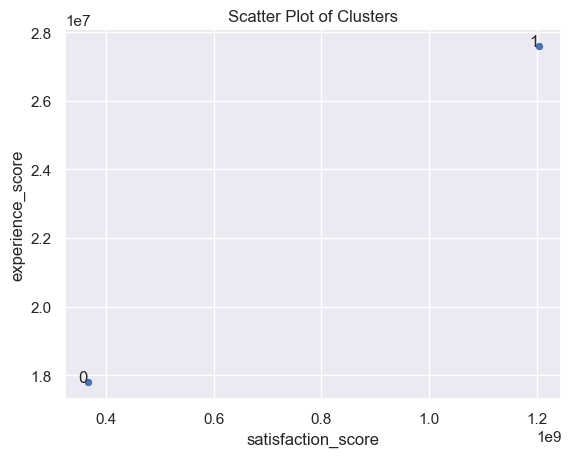

In [145]:
# plot the average of the clusters
sns.scatterplot(x=engagement_avg_aggregate['satisfaction_score'], y=engagement_avg_aggregate['experience_score'])

plt.title(f'Scatter Plot of Clusters')

# add lable to the points
for i in range(len(engagement_avg_aggregate)):
    plt.text(engagement_avg_aggregate['satisfaction_score'][i], engagement_avg_aggregate['experience_score'][i], engagement_avg_aggregate.index[i], fontsize=12, ha='right')

As we can see from the plot the two clusters have the following properties:
- Cluster 0: have low satisfaction and experience scores, so we can say they are groups that aren't satisfied by the service.
- Cluster 1: have high satisfaction and experience scores, so we can say they are groups that are satisfied by the service.

Besides that we can say that the satisfaction score is strongly related to experience score. We can see that from the graph, and also we literally have it in the equation for finding the satisfaction score

In [149]:
# aggregate the user data based on engagement cluster
experience_avg_aggregate = user_data.groupby(by='experience_cluster').agg({
    "satisfaction_score": "mean",
    "engagement_score": "mean"
})

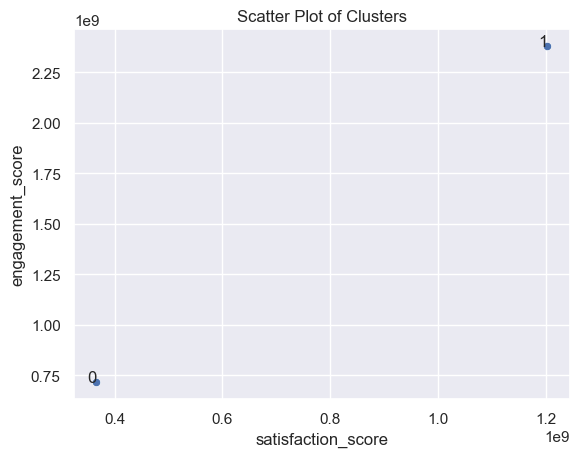

In [150]:
# plot the average of the clusters
sns.scatterplot(x=experience_avg_aggregate['satisfaction_score'], y=experience_avg_aggregate['engagement_score'])

plt.title(f'Scatter Plot of Clusters')

# add lable to the points
for i in range(len(experience_avg_aggregate)):
    plt.text(experience_avg_aggregate['satisfaction_score'][i], experience_avg_aggregate['engagement_score'][i], experience_avg_aggregate.index[i], fontsize=12, ha='right')

The same results as the previous one can be seen on this plot also

6)  Build a regression model that can predict the satisfaction score of a user

7) Export the resulting user id and satisfaction, engagement and experience scores 